# <center> Wavefront set inpainting real phantom </center>

In this notebook we are implementing a Wavefront set inpainting algorithm based on a hallucination network

In [4]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
# Import the needed modules
from data.data_factory import generate_realphantom_WFinpaint, DataGenerator_realphantom_WFinpaint
from ellipse.ellipseWF_factory import plot_WF 

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/WF_inpaint/data/data_factory.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in lau

/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/WF_inpaint/realphantom/realphantomWF_factory.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", 

## Data generator

In [6]:
batch_size = 1
size = 256
nClasses = 180
lowd = 40

In [7]:
y_arr, x_true_arr =generate_realphantom_WFinpaint(batch_size, size, nClasses, lowd)

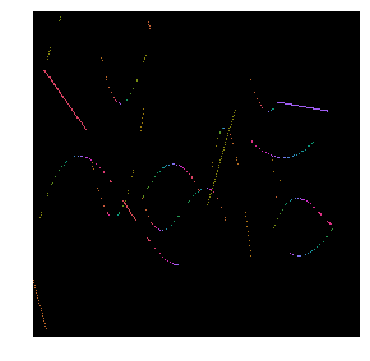

In [8]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(y_arr[0,:,:,0])

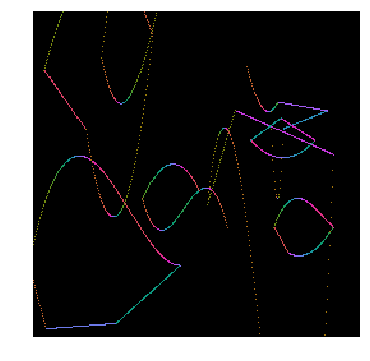

In [9]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(x_true_arr[0,:,:,0])

## Load the model

In [10]:
# Tensorflow and seed
seed_value = 0
import random
random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)

# Importing relevant keras modules
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from shared.shared import create_increasing_dir
import pickle

In [11]:
# Import model and custom losses
from models.unet import UNet
from models.losses import CUSTOM_OBJECTS

In [12]:
# Parameters for the training
learning_rate = 1e-3
loss = 'mae'
batch_size = 50
epoches = 10000

In [ ]:
pretrained = 1
path_to_model_dir = './models/unets_realphantom_WFinpaint/training_5'

In [ ]:
# Data generator
size = 256
nClasses = 180
lowd = 40
train_gen = DataGenerator_realphantom_WFinpaint(batch_size, size, nClasses, lowd)
val_gen = DataGenerator_realphantom_WFinpaint(batch_size, size, nClasses, lowd)

In [ ]:
if pretrained==0:
    # Create a fresh model
    print("Create a fresh model")
    unet = UNet()
    model = unet.create_model( img_shape = (size, size, 1) , loss = loss, learning_rate = learning_rate)
    path_to_training = create_increasing_dir('./models/unets_realphantom_WFinpaint', 'training')
    print("Save training in {}".format(path_to_training))
    path_to_model_dir = path_to_training
    
else: 
    print("Use trained model as initialization:")
    print(path_to_model_dir+"/weights.hdf5")
    model = load_model(path_to_model_dir+"/weights.hdf5",
                       custom_objects=CUSTOM_OBJECTS)
    path_to_training = path_to_model_dir

Use trained model as initialization:
./models/unets_realphantom_WFinpaint/training_5/weights.hdf5
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [ ]:
# Callbacks for saving model
context = {
    "loss": loss,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "path_to_model_dir": path_to_model_dir,
}
path_to_context = path_to_training+'/context.log'

with open(path_to_context, 'wb') as dict_items_save:
    pickle.dump(context, dict_items_save)
print("Save training context to {}".format(path_to_context))

# Save architecture
model_json = model.to_json()
path_to_architecture = path_to_training + "/model.json"
with open(path_to_architecture, "w") as json_file:
    json_file.write(model_json)
print("Save model architecture to {}".format(path_to_architecture))

# Checkpoint for trained model
checkpoint = ModelCheckpoint(
    path_to_training+'/weights.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True)
csv_logger = CSVLogger(path_to_training+'/training.log')

callbacks_list = [checkpoint, csv_logger]

Save training context to ./models/unets_realphantom_WFinpaint/training_5/context.log
Save model architecture to ./models/unets_realphantom_WFinpaint/training_5/model.json


In [ ]:
model.fit_generator(train_gen,epochs=epoches, steps_per_epoch=5600 // batch_size,
                    callbacks=callbacks_list, validation_data=val_gen, validation_steps= 2000// batch_size)

Epoch 1/10000
111/112 [============================>.] - ETA: 13s - loss: 0.9985 - my_mean_squared_error: 111.1464 - mean_squared_error: 111.1464 - mean_absolute_error: 0.9985 - l2_on_wedge: 107.8654 - my_psnr: -5.8870